# TIME SERIES FORECASTING OF PROJECT TWEETS BIG DATA PROCESSED WITH SPARK AND STORED IN MONGODB

# Dataset
The dataste is a large dataset gleaned from the twitter API that is called ProjectTweets.csv.

This dataset contains 1,600,000 tweets extracted using the twitter api. 


Content
It contains the following 5 fields:
- ids: The id of the tweet (eg. 4587)
- date: the date of the tweet (eg. Sat May 16 23:58:44 UTC 2009)
- flag: The query (eg. lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (eg. bobthebuilder)
- text: the text of the tweet (eg. Lyx is cool)

## Install all Required Libraries

In [1]:
#Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col, lower, regexp_replace, trim, split, udf
from pyspark.sql.functions import isnull, to_timestamp
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StringType, TimestampType
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
#Creating a pyspark session connecting to mongodb
uri = "mongodb://172.17.0.8:27017/DeeProject_mongo.Tweets"

spark = SparkSession.builder.appName("Write into MongoDB")\
    .config("spark.mongodb.input.uri", uri)\
    .config("spark.mongodb.output.uri", uri)\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
    .getOrCreate()

In [3]:
#Spark content
spark

# Step one: Writing Data into MongoDB using Apache Spark

## Loading data from local machine to SParkSQL

In [4]:
#Set legacy timeParserPolicy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

#Define the schema for the csv file 
schema = StructType().add("_c0", StringType(), True).add("_c1", StringType(), True).add("_c2", StringType(), True).add("_c3", StringType(), True).add("_c4", StringType(), True).add("_c5", StringType(), True)

#Read the CSV into a DataFrame called df
df = spark.read.format("csv").option("header", False).schema(schema).load("file:///home/jovyan/Diana/ProjectTweets.csv")

#Rename the headers
df = df.withColumnRenamed("_c0", "PRIMARY KEY").withColumnRenamed("_c1", "ID").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

#Convert string date to TimestampType
df = df.withColumn("date", to_timestamp(df["date"], "EEE MMM dd HH:mm:ss zzzz yyyy"))

#Print schema
df.printSchema()

#Show DataFrame
df.show(5)


root
 |-- PRIMARY KEY: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+-----------+----------+-------------------+--------+---------------+--------------------+
|PRIMARY KEY|        ID|               date|    flag|           user|                text|
+-----------+----------+-------------------+--------+---------------+--------------------+
|          0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|          1|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|          2|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|          3|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|          4|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
+-----------+----------+------------------

## Write data from spark to MongoDB

In [5]:
#Write data into MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", uri).save()

# Step Two: Read the Project Tweets data from MongoDB using Spark

In [6]:
#Read Data from MongoDB
from_mongo = spark.read.format('com.mongodb.spark.sql.DefaultSource').load()
print((from_mongo.count(), len(from_mongo.columns)))
from_mongo.printSchema()
from_mongo.show(5)

(1600000, 7)
root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|
|1990436582|    122363

# EXPLORATORY DATA ANALYSIS

# Checking for Duplicates (based on ID, user and text) and Missing data

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum  # Import the 'col' and 'sum' functions

#Initialize Spark Session
spark = SparkSession.builder.appName("Duplicate and Missing Data Check").getOrCreate()

#Define the columns to check for duplicates and missing values
columns_to_check = ['PRIMARY KEY','ID', 'user', 'text']

#Create a pipeline to check for duplicates and missing values
pipeline_df = from_mongo

#Step 1: Remove duplicate records based on specified columns
pipeline_df = pipeline_df.dropDuplicates(subset=columns_to_check)

#Step 2: Check for missing values
missing_counts = pipeline_df.select([col(c).isNull().cast("int").alias(c) for c in columns_to_check]).agg(*[sum(c).alias(c) for c in columns_to_check]).collect()[0]

#Print the results
print("Number of duplicate records removed:", df.count() - pipeline_df.count())

print("Missing value counts:")
for col_name, missing_count in zip(columns_to_check, missing_counts):
    print(col_name, missing_count)

Number of duplicate records removed: 0
Missing value counts:
PRIMARY KEY 0
ID 0
user 0
text 0


In [8]:
#Checking for duplicates in ID and user name
#Count the number of rows before removing duplicates
count_before = from_mongo.count()

#Remove duplicates
df_no_duplicates = from_mongo.dropDuplicates()

#Count the number of rows after removing duplicates
count_after = df_no_duplicates.count()

#Calculate the number of duplicates
num_duplicates = count_before - count_after

print(f"Number of duplicate rows removed: {num_duplicates}")

Number of duplicate rows removed: 0


In [9]:
#Count the number of rows before removing duplicates
count_before = from_mongo.count()

#Remove duplicates based on a specific column
df_no_duplicates = from_mongo.dropDuplicates(subset=['user'])

#Count the number of rows after removing duplicates
count_after = df_no_duplicates.count()

#Calculate the number of duplicates
num_duplicates = count_before - count_after

print(f"Number of duplicate rows removed based on user: {num_duplicates}")

Number of duplicate rows removed based on user: 940225


# Summary Statistics

In [10]:
#Summary Statistics
from_mongo.describe().show()

+-------+--------------------+------------------+--------+--------------------+--------------------+
|summary|                  ID|       PRIMARY KEY|    flag|                text|                user|
+-------+--------------------+------------------+--------+--------------------+--------------------+
|  count|             1600000|           1600000| 1600000|             1600000|             1600000|
|   mean|1.9988175522956276E9|          799999.5|    NULL|                NULL| 4.325887521835714E9|
| stddev|1.9357607362267783E8|461880.35968924506|    NULL|                NULL|5.162733218454889E10|
|    min|          1467810369|                 0|NO_QUERY|                 ...|        000catnap000|
|    max|          2329205794|            999999|NO_QUERY|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|          zzzzeus111|
+-------+--------------------+------------------+--------+--------------------+--------------------+



# EXTRACTING TIME COMPONENTS

In [11]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second


#Initialize Spark Session
spark = SparkSession.builder.appName("DateTime Visualization").getOrCreate()

#Extract relevant time components including hours, minutes, and seconds
df = from_mongo.withColumn("year", year("date")).withColumn("month", month("date")).withColumn("day", dayofmonth("date")).withColumn("hour", hour("date")).withColumn("minute", minute("date")).withColumn("second", second("date"))

#Aggregate data
time_series_data = df.groupBy("date","year", "month", "day", "hour", "minute", "second").count().orderBy("year", "month", "day", "hour", "minute", "second")

In [12]:
#View the df DataFrame after extracting time components
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|2009|    4| 18|  15|    51|    40|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|2009|    6|  7|   0|     2|    45|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......| jflinchbaugh|2009|    6|  1|  11|    52|

In [13]:
#View the Spark DataFrame Features
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



In [14]:
from pyspark.sql.functions import count

#Group by the year variable and count the occurrences
year_counts = df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

#Show the tabulated counts
year_counts.show()

+----+-------+
|year|  count|
+----+-------+
|2009|1600000|
+----+-------+



In [15]:
from pyspark.sql.functions import count

#Group by the month variable and count the occurrences
month_counts = df.groupBy("month").agg(count("*").alias("count")).orderBy("month")

#Show the tabulated counts
month_counts.show()

+-----+------+
|month| count|
+-----+------+
|    4|100025|
|    5|559073|
|    6|940902|
+-----+------+



In [16]:
from pyspark.sql.functions import count

#Group by the day variable and count the occurrences
day_counts = df.groupBy("day").agg(count("*").alias("count")).orderBy("day")

#Show the tabulated counts
day_counts.show()

+---+------+
|day| count|
+---+------+
|  1| 95449|
|  2|108872|
|  3| 86707|
|  4| 32938|
|  5| 34735|
|  6|104793|
|  7|132564|
|  8| 18566|
| 10| 31551|
| 11|  6217|
| 12|  4186|
| 14| 22026|
| 15| 83309|
| 16| 87524|
| 17| 85236|
| 18|105040|
| 19| 75612|
| 20| 64029|
| 21| 41782|
| 22| 49519|
+---+------+
only showing top 20 rows



In [17]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
day_counts = df.groupBy("month","day").agg(count("*").alias("count")).orderBy("month")

# Show the tabulated counts
day_counts.show()

+-----+---+------+
|month|day| count|
+-----+---+------+
|    4|  7| 20671|
|    4| 18| 17154|
|    4| 20| 18447|
|    4| 21| 11105|
|    4| 19| 32648|
|    5|  4| 28300|
|    5| 10| 31551|
|    5|  2| 31096|
|    5|  3| 26568|
|    5| 22| 41206|
|    5| 24|   169|
|    5| 17| 41205|
|    5| 12|  4186|
|    5| 29| 60227|
|    5| 18| 44564|
|    5| 27| 11619|
|    5| 11|  6217|
|    5| 14| 21526|
|    5| 25|   169|
|    5| 30|104484|
+-----+---+------+
only showing top 20 rows



In [18]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
ID_counts = df.groupBy("ID").agg(count("*").alias("count")).orderBy("ID")

# Show the tabulated counts
ID_counts.show()

+----------+-----+
|        ID|count|
+----------+-----+
|1467810369|    1|
|1467810672|    1|
|1467810917|    1|
|1467811184|    1|
|1467811193|    1|
|1467811372|    1|
|1467811592|    1|
|1467811594|    1|
|1467811795|    1|
|1467812025|    1|
|1467812416|    1|
|1467812579|    1|
|1467812723|    1|
|1467812771|    1|
|1467812784|    1|
|1467812799|    1|
|1467812964|    1|
|1467813137|    1|
|1467813579|    1|
|1467813782|    1|
+----------+-----+
only showing top 20 rows



In [19]:
time_series_data.show(5)

+-------------------+----+-----+---+----+------+------+-----+
|               date|year|month|day|hour|minute|second|count|
+-------------------+----+-----+---+----+------+------+-----+
|2009-04-07 05:19:45|2009|    4|  7|   5|    19|    45|    1|
|2009-04-07 05:19:49|2009|    4|  7|   5|    19|    49|    1|
|2009-04-07 05:19:53|2009|    4|  7|   5|    19|    53|    1|
|2009-04-07 05:19:57|2009|    4|  7|   5|    19|    57|    2|
|2009-04-07 05:20:00|2009|    4|  7|   5|    20|     0|    1|
+-------------------+----+-----+---+----+------+------+-----+
only showing top 5 rows



In [20]:
type(time_series_data)

pyspark.sql.dataframe.DataFrame

In [21]:
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|2009|    4| 18|  15|    51|    40|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|2009|    6|  7|   0|     2|    45|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......| jflinchbaugh|2009|    6|  1|  11|    52|

In [22]:
type(df)

pyspark.sql.dataframe.DataFrame

In [23]:
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|2009|    4| 18|  15|    51|    40|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|2009|    6|  7|   0|     2|    45|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......| jflinchbaugh|2009|    6|  1|  11|    52|

In [24]:
df = df.drop("_id", "ID", "PRIMARY KEY")

In [25]:
df.show()

+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|               date|    flag|                text|           user|year|month|day|hour|minute|second|
+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|  prosario_2000|2009|    4| 18|  15|    51|    40|
|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|          l7l7v|2009|    6|  7|   0|     2|    45|
|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|           kmdk|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|   jflinchbaugh|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|      kittaykat|2009|    6|  1|  11|    52|     4|
|2009-04-18 15:51:39|NO_QUERY|@Boy_Kill_Boy Nop...|Chelsea_Volturi|2009|    4| 18|  15|    51|    39|
|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|          Mm_Ka|2009|    6|  1|

## Save the df Dataframe as a Pandas

In [26]:
data = df.collect()

In [27]:
#import pandas as pd
#Create pandas DataFrame from the list of rows
pandas_df = pd.DataFrame(data)

In [28]:
pandas_df.columns = df.columns 

In [29]:
pandas_df.shape

(1600000, 10)

In [31]:
#file path where you want to save the CSV file
file_path = "pandas_data.csv"

# Save the DataFrame to a CSV file
pandas_df.to_csv(file_path)

# Save the processed Data to MongoDB

In [32]:
#Write data into MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", uri).save()

## SENTIMENT ANALYSIS COMPARING VADER VS TEXTBLOB, THEN TIME SERIES FORECASTING

## Text/Tweets Processing
This includes the following steps:-
- Read and Load the Dataset
- Exploratory Data Analysis
- Data Visualization of Target Variables
- Data Preprocessing
- Splitting our data into Train and Test sets.
- Transforming Dataset using TF-IDF Vectorizer
- Function for Model Evaluation
- Model Building
- Model Evaluation

# Read the  pandas_data csv

In [1]:
import pandas as pd

#Load the data
df = pd.read_csv("C:/Users/Diana/Documents/Semester 2/sem two ca 2/pandas_data.csv")

## Exploratory Data Analysis

This process involves:-

a) View the first and last few observations of the df dataframe

b) View the number of observations and variables the df dataframe has

c) View the entire df dataframe to check the data types and any missing data in a particluar variable.
 
d) Checking for missing data/dates


In [2]:
#View the first few observations of the df DataFrame
df.head(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
0,0,2009-04-18 15:51:40,NO_QUERY,@ctribe I hope you are having a great day.,prosario_2000,2009,4,18,15,51,40
1,1,2009-06-07 00:02:45,NO_QUERY,Kinda scared to sleep alone in this house toni...,l7l7v,2009,6,7,0,2,45
2,2,2009-06-01 11:52:03,NO_QUERY,@karinhoegh Didn't think of national holidays...,kmdk,2009,6,1,11,52,3
3,3,2009-06-01 11:52:03,NO_QUERY,Need more FPS....time to shop for a new camera...,jflinchbaugh,2009,6,1,11,52,3
4,4,2009-06-01 11:52:04,NO_QUERY,@SteveOGallagher take me with u,kittaykat,2009,6,1,11,52,4


In [3]:
#View the last few observations of the df DataFrame
df.tail(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
1599995,1599995,2009-06-07 00:02:36,NO_QUERY,"I just got a bunch of money for graduation, bu...",chichi7391,2009,6,7,0,2,36
1599996,1599996,2009-06-07 00:02:40,NO_QUERY,were is my pic,lambrinilesley,2009,6,7,0,2,40
1599997,1599997,2009-06-07 00:02:41,NO_QUERY,@sar_88 you had to wait 2 hours for the foood,sweetmash,2009,6,7,0,2,41
1599998,1599998,2009-06-07 00:02:41,NO_QUERY,@pollyyy by the way i hate you for seeing bran...,LittleBirkett,2009,6,7,0,2,41
1599999,1599999,2009-06-07 00:02:41,NO_QUERY,Not looking forward to a good 9 hours at One P...,paul_hauffe,2009,6,7,0,2,41


In [4]:
#View the shape of the df DataFrame
df.shape

(1600000, 11)

In [5]:
#View the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1600000 non-null  int64 
 1   date        1600000 non-null  object
 2   flag        1600000 non-null  object
 3   text        1600000 non-null  object
 4   user        1600000 non-null  object
 5   year        1600000 non-null  int64 
 6   month       1600000 non-null  int64 
 7   day         1600000 non-null  int64 
 8   hour        1600000 non-null  int64 
 9   minute      1600000 non-null  int64 
 10  second      1600000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 134.3+ MB


In [6]:
# Convert the 'date_column' to datetime datatype
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Check if the date has been changed to date time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Unnamed: 0  1600000 non-null  int64         
 1   date        1600000 non-null  datetime64[ns]
 2   flag        1600000 non-null  object        
 3   text        1600000 non-null  object        
 4   user        1600000 non-null  object        
 5   year        1600000 non-null  int64         
 6   month       1600000 non-null  int64         
 7   day         1600000 non-null  int64         
 8   hour        1600000 non-null  int64         
 9   minute      1600000 non-null  int64         
 10  second      1600000 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 134.3+ MB


In [8]:
#Check the df
df.head(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
0,0,2009-04-18 15:51:40,NO_QUERY,@ctribe I hope you are having a great day.,prosario_2000,2009,4,18,15,51,40
1,1,2009-06-07 00:02:45,NO_QUERY,Kinda scared to sleep alone in this house toni...,l7l7v,2009,6,7,0,2,45
2,2,2009-06-01 11:52:03,NO_QUERY,@karinhoegh Didn't think of national holidays...,kmdk,2009,6,1,11,52,3
3,3,2009-06-01 11:52:03,NO_QUERY,Need more FPS....time to shop for a new camera...,jflinchbaugh,2009,6,1,11,52,3
4,4,2009-06-01 11:52:04,NO_QUERY,@SteveOGallagher take me with u,kittaykat,2009,6,1,11,52,4


## Drop Variables that will not be used

In [9]:
# Drop all columns except 'date' and 'text'
df = df[['date', 'text']]

In [10]:
#Check if they have been dropped
df.head(5)

,date,text
0,2009-04-18 15:51:40,@ctribe I hope you are having a great day.
1,2009-06-07 00:02:45,Kinda scared to sleep alone in this house toni...
2,2009-06-01 11:52:03,@karinhoegh Didn't think of national holidays...
3,2009-06-01 11:52:03,Need more FPS....time to shop for a new camera...
4,2009-06-01 11:52:04,@SteveOGallagher take me with u


In [11]:
# Sort the DataFrame by the 'date' column in ascending order
df = df.sort_values(by='date', ascending=True)

In [12]:
#Check if the date is sorted
df.head(5)

,date,text
271,2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
275,2009-04-07 05:19:49,is upset that he can't update his Facebook by ...
277,2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...
279,2009-04-07 05:19:57,my whole body feels itchy and like its on fire
281,2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all...."


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 271 to 1546305
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1600000 non-null  datetime64[ns]
 1   text    1600000 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 36.6+ MB


In [14]:
# Convert 'date' column to datetime format if it's not already in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract month from 'date' column
df['month'] = df['date'].dt.to_period('M')

#Group by month and find minimum and maximum date for each month
monthly_date_range = df.groupby('month')['date'].agg([min, max])

#Display the result
print(monthly_date_range)

                        min                 max
month                                          
2009-04 2009-04-07 05:19:45 2009-04-21 11:22:15
2009-05 2009-05-02 03:08:46 2009-05-31 23:59:59
2009-06 2009-06-01 00:00:00 2009-06-25 17:28:31


## The dates have some missing dates
- The data is for 3 months, April, May, June
- April (7/4/2009 - 21/4/2009)
- May (2/5/2009) - 31/5/2009
- June (1/6/2009 -25/6/2009)

In [15]:
# Count the number of dates by month
monthly_date_counts = df.groupby('month').size()

# Display the result
print(monthly_date_counts)


month
2009-04    100025
2009-05    559073
2009-06    940902
Freq: M, dtype: int64


In [16]:
df['day'] = df['date'].dt.to_period('D')

# Count the number of dates by month
dm_date_counts = df.groupby(['month', 'day']).size()

# Display the result
print(dm_date_counts)


month    day       
2009-04  2009-04-07     20671
         2009-04-18     17154
         2009-04-19     32648
         2009-04-20     18447
         2009-04-21     11105
2009-05  2009-05-02     31096
         2009-05-03     26568
         2009-05-04     28300
         2009-05-10     31551
         2009-05-11      6217
         2009-05-12      4186
         2009-05-14     21526
         2009-05-17     41205
         2009-05-18     44564
         2009-05-22     41206
         2009-05-24       169
         2009-05-25       169
         2009-05-27     11619
         2009-05-29     60227
         2009-05-30    104484
         2009-05-31    105986
2009-06  2009-06-01     95449
         2009-06-02     77776
         2009-06-03     60139
         2009-06-04      4638
         2009-06-05     34735
         2009-06-06    104793
         2009-06-07    111893
         2009-06-08     18566
         2009-06-14       500
         2009-06-15     83309
         2009-06-16     87524
         2009-06-17 

There are missing dates in each month

In [17]:
# Count the number of unique dates
unique_date_counts = df['date'].nunique()

# Display the result
print("Number of unique dates:", unique_date_counts)



Number of unique dates: 774363


In [20]:
#View the df
df.head(5)

,text,month,day
date,,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04,2009-04-07
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,2009-04,2009-04-07
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,2009-04,2009-04-07
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,2009-04,2009-04-07
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",2009-04,2009-04-07


# EDA of the Texts

In [21]:
#Count the number of words in the text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [22]:
df[["text","word_count"]].head(5)

,text,word_count
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",20
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,22
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,19
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,11
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",22


In [23]:
#Find the maximum number of words in the 'word_count' variable of the 'df' DataFrame
largest_word_count = df["word_count"].max()
largest_word_count

110

In [24]:
#Count the number of characters in the text variable
df['char_count'] = df['text'].str.len() 

In [25]:
#View the head of the char_count and text
df[["text","char_count"]].head(5)

,text,char_count
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,111
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,89
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,47
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",111


In [26]:
#Find the maximum number of characters in the 'char_count' variable of the 'df' DataFrame
largest_char_count = df["char_count"].max()
largest_char_count

374

In [27]:
#define a function to calculate the average length of words in a sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [28]:
#Apply the avg_word function on text
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

In [29]:
#View text and avg_word
df[['text','avg_word']].head()

,text,avg_word
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",5.052632
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,4.285714
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,3.944444
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,3.700000
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",4.285714


In [30]:
#Find the highest average word count of the 'df' DataFrame
highest_avg_word = df["avg_word"].max()
highest_avg_word

137.0

In [31]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [32]:
#count number of stopwords in each text and store in a variable called stopwords
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head(5)

,text,stopwords
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,8
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,5
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,4
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",10


In [33]:
#Find the maximum number of stopwords in the 'df' DataFrame
maximum_no_stopwords = df["stopwords"].max()
maximum_no_stopwords

25

In [34]:
#Count number of hashtags in each text and store in a variable called hastags
df['hashtags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text','hashtags']].head(5)

,text,hashtags
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,0
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,0
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,0
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",0


In [35]:
#Find the maximum number of hashtags in the 'df' DataFrame
maximum_no_hashtags = df["hashtags"].max()
maximum_no_hashtags

24

In [36]:
#count number of @ signs in text variable and store the value in a variable called at_sign
df['at_sign'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','at_sign']].head(5)

,text,at_sign
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,0
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,1
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,0
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",1


In [37]:
#Find the maximum number of at_sign in the 'df' DataFrame
maximum_no_atsign = df["at_sign"].max()
maximum_no_atsign

12

In [38]:
#count number of numerics in the text variable and store the value in a variable called numeric
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head(5)

,text,numerics
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,0
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,0
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,0
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",0


In [39]:
#Find the maximum number of numerics in the 'df' DataFrame
maximum_no_numerics = df["numerics"].max()
maximum_no_numerics

13

In [40]:
#count number of uppercases in the text variable and store the value in a variable called upper
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text','upper']].head(5)

,text,upper
date,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,0
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,1
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,0
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",1


In [41]:
#Find the maximum number of uppercases in the 'df' DataFrame
maximum_no_uppercases = df["upper"].max()
maximum_no_uppercases

40

## Tweets Processing
Tweet/text processing involves:-

a) Text Normalization 
- Remove special characters
- Change the upper cases to lower cases
- Remove numbers/integers
- Remove punctuations
- Remove white space
- Remove URLS/links

b) Tokenization
- Tokenization

c) Remove stopwords

d) Stemming/ lemmatization

e

## Text Normalization

### Remove user name from text @username

In [42]:
import re

#Define a function to remove user names from text
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

#Apply the function to the 'text' variable
df['text1'] = df['text'].apply(remove_usernames)

# Print the first few rows of the DataFrame with user names removed from text
print(df['text1'].head())


date
2009-04-07 05:19:45     http://twitpic.com/2y1zl - Awww, that's a bum...
2009-04-07 05:19:49    is upset that he can't update his Facebook by ...
2009-04-07 05:19:53     I dived many times for the ball. Managed to s...
2009-04-07 05:19:57      my whole body feels itchy and like its on fire 
2009-04-07 05:19:57     no, it's not behaving at all. i'm mad. why am...
Name: text1, dtype: object


### Remove url/www.links

In [43]:
import re

def remove_urls(df):
    #Define regex pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    #Apply regex substitution to each row of the 'text' column
    df['text1'] = df['text1'].apply(lambda text: re.sub(url_pattern, '', text))
    
    return df

# remove a url
df = remove_urls(df)


In [44]:
df.head(5)

,text,month,day,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,upper,text1
date,,,,,,,,,,,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04,2009-04-07,20,115,5.052632,4,0,1,0,1,"- Awww, that's a bummer. You shoulda got Da..."
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,2009-04,2009-04-07,22,111,4.285714,8,0,0,0,0,is upset that he can't update his Facebook by ...
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,2009-04,2009-04-07,19,89,3.944444,5,0,1,0,1,I dived many times for the ball. Managed to s...
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,2009-04,2009-04-07,11,47,3.700000,4,0,0,0,0,my whole body feels itchy and like its on fire
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",2009-04,2009-04-07,22,111,4.285714,10,0,1,0,1,"no, it's not behaving at all. i'm mad. why am..."


### Remove all special characters

In [45]:
#Remove all special characters
df['text1'] = df['text1'].str.replace('[^\w\s]','')
df['text1'].head(5)

C:\Users\Diana\AppData\Local\Temp\ipykernel_16768\1096157190.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text1'] = df['text1'].str.replace('[^\w\s]','')


date
2009-04-07 05:19:45       Awww thats a bummer  You shoulda got David ...
2009-04-07 05:19:49    is upset that he cant update his Facebook by t...
2009-04-07 05:19:53     I dived many times for the ball Managed to sa...
2009-04-07 05:19:57      my whole body feels itchy and like its on fire 
2009-04-07 05:19:57     no its not behaving at all im mad why am i he...
Name: text1, dtype: object

### Remove punctuations

In [46]:
#Remove punctuations
import string

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#Apply remove_punctuation function to the 'text' column
df['text1'] = df['text1'].apply(remove_punctuation)


In [47]:
df.head(5)

,text,month,day,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,upper,text1
date,,,,,,,,,,,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04,2009-04-07,20,115,5.052632,4,0,1,0,1,Awww thats a bummer You shoulda got David ...
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,2009-04,2009-04-07,22,111,4.285714,8,0,0,0,0,is upset that he cant update his Facebook by t...
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,2009-04,2009-04-07,19,89,3.944444,5,0,1,0,1,I dived many times for the ball Managed to sa...
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,2009-04,2009-04-07,11,47,3.700000,4,0,0,0,0,my whole body feels itchy and like its on fire
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",2009-04,2009-04-07,22,111,4.285714,10,0,1,0,1,no its not behaving at all im mad why am i he...


### Convert all upper cases to lower

In [48]:
#Convert all uppercases to lower cases
df['text1'] = df['text1'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text1'].head(5)

date
2009-04-07 05:19:45    awww thats a bummer you shoulda got david carr...
2009-04-07 05:19:49    is upset that he cant update his facebook by t...
2009-04-07 05:19:53    i dived many times for the ball managed to sav...
2009-04-07 05:19:57       my whole body feels itchy and like its on fire
2009-04-07 05:19:57    no its not behaving at all im mad why am i her...
Name: text1, dtype: object

## Tokenization

In [49]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Word Tokenization

In [50]:
from nltk.tokenize import word_tokenize

#Tokenize the text using NLTK's word tokenizer
df['tokenized_text'] = df['text1'].apply(lambda x: ' '.join(word_tokenize(x.lower())))

#Print the first few rows of the DataFrame with tokenized text
df[['text1', 'tokenized_text']].head(5)

,text1,tokenized_text
date,,
2009-04-07 05:19:45,awww thats a bummer you shoulda got david carr...,awww thats a bummer you shoulda got david carr...
2009-04-07 05:19:49,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...
2009-04-07 05:19:53,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
2009-04-07 05:19:57,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...


## Remove stopwords

In [51]:
from nltk.corpus import stopwords

#Download NLTK resources for the first time
nltk.download('stopwords')

#Get the English stopwords list
stop_words = set(stopwords.words('english'))

#Function to remove stopwords
def remove_stopwords(tokenized_text):
    return ' '.join([word for word in tokenized_text.split() if word.lower() not in stop_words])

#Remove stopwords from the tokenized text column
df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)

# Print the first few rows of the DataFrame with stopwords removed
print(df[['text1', 'tokenized_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                                 text1  \
date                                                                     
2009-04-07 05:19:45  awww thats a bummer you shoulda got david carr...   
2009-04-07 05:19:49  is upset that he cant update his facebook by t...   
2009-04-07 05:19:53  i dived many times for the ball managed to sav...   
2009-04-07 05:19:57     my whole body feels itchy and like its on fire   
2009-04-07 05:19:57  no its not behaving at all im mad why am i her...   

                                                        tokenized_text  
date                                                                    
2009-04-07 05:19:45  awww thats bummer shoulda got david carr third...  
2009-04-07 05:19:49  upset cant update facebook texting might cry r...  
2009-04-07 05:19:53  dived many times ball managed save 50 rest go ...  
2009-04-07 05:19:57                   whole body feels itchy like fire  
2009-04-07 05:19:57                        

In [52]:
#Create a Frequency Distribution of the tokenized words
#Import Frequency Distribution
from nltk.probability import FreqDist

#Find frequency distribution of tokenized_text
fdist = FreqDist(df['tokenized_text'])

In [53]:
#Check top 5 common words
fdist.most_common(5)

[('', 6847),
 ('thanks', 2329),
 ('thank', 1573),
 ('get 100 followers day using add everyone train pay vip', 1484),
 ('good morning', 1134)]

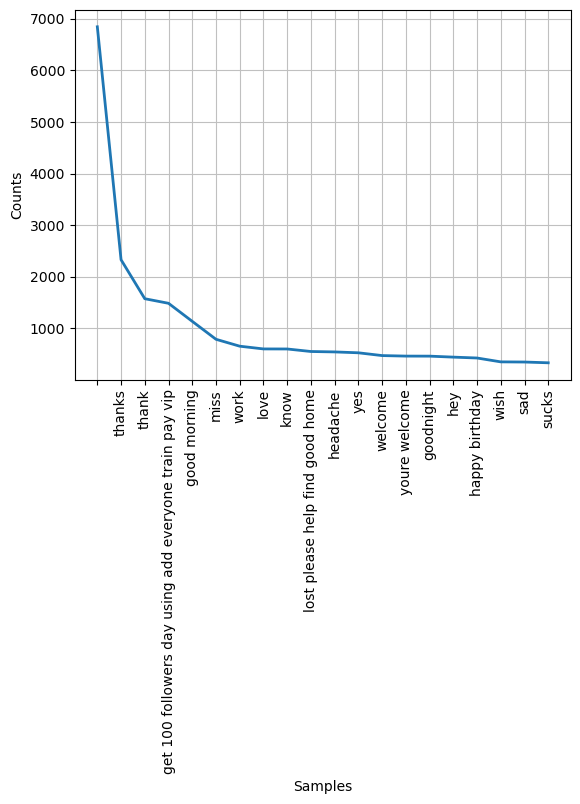

In [54]:
#Create a frequency distribution plot
import matplotlib.pyplot as plt

#Plot Frequency Distribution
fdist.plot(20,cumulative=False)
plt.show()

## Stemming/ lemmatization

In [55]:
from nltk.stem import WordNetLemmatizer

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(tokenized_text):
    #Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokenized_text.split()]
    
    #Join the lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

#Apply lemmatization to 'tokenized_text' column in DataFrame df
df['preprocessed_text'] = df['tokenized_text'].apply(lemmatize_text)

#Print the first few rows of the DataFrame with lemmatized text
print(df[['tokenized_text', 'preprocessed_text']].head(5))

                                                        tokenized_text  \
date                                                                     
2009-04-07 05:19:45  awww thats bummer shoulda got david carr third...   
2009-04-07 05:19:49  upset cant update facebook texting might cry r...   
2009-04-07 05:19:53  dived many times ball managed save 50 rest go ...   
2009-04-07 05:19:57                   whole body feels itchy like fire   
2009-04-07 05:19:57                           behaving im mad cant see   

                                                     preprocessed_text  
date                                                                    
2009-04-07 05:19:45  awww thats bummer shoulda got david carr third...  
2009-04-07 05:19:49  upset cant update facebook texting might cry r...  
2009-04-07 05:19:53  dived many time ball managed save 50 rest go b...  
2009-04-07 05:19:57                    whole body feel itchy like fire  
2009-04-07 05:19:57                        

# SENTIMENT ANALYSIS
There are various ways to perform sentiment analysis. These include:-
- Using Text Blob
- Using Vader
- Using Bag of Words Vectorization-based Models
- Using LSTM-based Models
- Using Transformer-based Models

## USING TEXTBLOB
-  It takes text as an input and can return polarity and subjectivity as outputs.

- Polarity determines the sentiment of the text. Its values lie in [-1,1] where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.

- Subjectivity determines whether a text input is factual information or a personal opinion. Its value lies between [0,1] where a value closer to 0 denotes a piece of factual information and a value closer to 1 denotes a personal opinion.

In [56]:
from textblob import TextBlob

#Apply sentiment analysis using TextBlob to the 'text' column and storing the polarity score
df['polarity_score'] = df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment[0] )
df[['preprocessed_text','polarity_score']].head(5)

,preprocessed_text,polarity_score
date,,
2009-04-07 05:19:45,awww thats bummer shoulda got david carr third...,0.200
2009-04-07 05:19:49,upset cant update facebook texting might cry r...,0.000
2009-04-07 05:19:53,dived many time ball managed save 50 rest go b...,0.500
2009-04-07 05:19:57,whole body feel itchy like fire,0.200
2009-04-07 05:19:57,behaving im mad cant see,-0.625


In [57]:
#View the df, first 5 observations
df.head(5)

,text,month,day,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,upper,text1,tokenized_text,preprocessed_text,polarity_score
date,,,,,,,,,,,,,,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04,2009-04-07,20,115,5.052632,4,0,1,0,1,awww thats a bummer you shoulda got david carr...,awww thats bummer shoulda got david carr third...,awww thats bummer shoulda got david carr third...,0.200
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,2009-04,2009-04-07,22,111,4.285714,8,0,0,0,0,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,0.000
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,2009-04,2009-04-07,19,89,3.944444,5,0,1,0,1,i dived many times for the ball managed to sav...,dived many times ball managed save 50 rest go ...,dived many time ball managed save 50 rest go b...,0.500
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,2009-04,2009-04-07,11,47,3.700000,4,0,0,0,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,whole body feel itchy like fire,0.200
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",2009-04,2009-04-07,22,111,4.285714,10,0,1,0,1,no its not behaving at all im mad why am i her...,behaving im mad cant see,behaving im mad cant see,-0.625


In [58]:
#View data types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600000 entries, 2009-04-07 05:19:45 to 2009-06-25 17:28:31
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype    
---  ------             --------------    -----    
 0   text               1600000 non-null  object   
 1   month              1600000 non-null  period[M]
 2   day                1600000 non-null  period[D]
 3   word_count         1600000 non-null  int64    
 4   char_count         1600000 non-null  int64    
 5   avg_word           1600000 non-null  float64  
 6   stopwords          1600000 non-null  int64    
 7   hashtags           1600000 non-null  int64    
 8   at_sign            1600000 non-null  int64    
 9   numerics           1600000 non-null  int64    
 10  upper              1600000 non-null  int64    
 11  text1              1600000 non-null  object   
 12  tokenized_text     1600000 non-null  object   
 13  preprocessed_text  1600000 non-null  object   
 14  polarity_score   

In [59]:
# Function to categorize sentiment polarities
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to classify polarity scores and store the result in 'textblob_sentiment' column
df['textblob_sentiment'] = df['polarity_score'].apply(categorize_sentiment)

# Print the first few rows of the DataFrame with 'textblob_sentiment' column
print(df[['preprocessed_text', 'polarity_score', 'textblob_sentiment']].head())

                                                     preprocessed_text  \
date                                                                     
2009-04-07 05:19:45  awww thats bummer shoulda got david carr third...   
2009-04-07 05:19:49  upset cant update facebook texting might cry r...   
2009-04-07 05:19:53  dived many time ball managed save 50 rest go b...   
2009-04-07 05:19:57                    whole body feel itchy like fire   
2009-04-07 05:19:57                           behaving im mad cant see   

                     polarity_score textblob_sentiment  
date                                                    
2009-04-07 05:19:45           0.200           Positive  
2009-04-07 05:19:49           0.000            Neutral  
2009-04-07 05:19:53           0.500           Positive  
2009-04-07 05:19:57           0.200           Positive  
2009-04-07 05:19:57          -0.625           Negative  


In [60]:
# Function to categorize sentiment polarities
# Categorize sentiment polarities
def categorize_sentiment(polarity):
    if polarity > 0:
        return 1  # Positive
    elif polarity < 0:
        return -1  # Negative
    else:
        return 0  # Neutral

# Apply the function to classify polarity scores and store the result in 'textblob_sentiment' column
df['textblobsentiment'] = df['polarity_score'].apply(categorize_sentiment)

#View the first few rows of the DataFrame with 'textblob_sentiment' column
df[['preprocessed_text', 'polarity_score', 'textblob_sentiment','textblobsentiment']].head(5)

,preprocessed_text,polarity_score,textblob_sentiment,textblobsentiment
date,,,,
2009-04-07 05:19:45,awww thats bummer shoulda got david carr third...,0.200,Positive,1
2009-04-07 05:19:49,upset cant update facebook texting might cry r...,0.000,Neutral,0
2009-04-07 05:19:53,dived many time ball managed save 50 rest go b...,0.500,Positive,1
2009-04-07 05:19:57,whole body feel itchy like fire,0.200,Positive,1
2009-04-07 05:19:57,behaving im mad cant see,-0.625,Negative,-1


# USING VADER SENTIMENT ANALYSIS

In [61]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [62]:
#Create a VADER SentimentIntensityAnalyzer instance
twitter_sentiment = SentimentIntensityAnalyzer()

#Create a function to get compound sentiment score using VADER
def get_sentiment_scores(text):
    return twitter_sentiment.polarity_scores(text)

#Apply the function to get the compound scores and store the values in vader_sentiment
df['vader_sentiment'] = df['preprocessed_text'].apply(get_sentiment_scores)

#Extract the 'neg', 'neu', 'pos', 'compound' scores from 'vader_sentiment'
df['vader_neg'] = df['vader_sentiment'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_sentiment'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_sentiment'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])

#Create a function to categorize sentiments based on compound scores
def categorize_sentiment(vader_compound):
    if vader_compound >= 0.05:
        return 'positive'
    elif vader_compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

#Apply the categorization function to create the 'sentiment' column
df['sentiment_vader'] = df['vader_compound'].apply(categorize_sentiment)

#Display the updated DataFrame with the 'sentiment' column
print(df[['preprocessed_text','vader_compound','sentiment_vader']])

                                                     preprocessed_text  \
date                                                                     
2009-04-07 05:19:45  awww thats bummer shoulda got david carr third...   
2009-04-07 05:19:49  upset cant update facebook texting might cry r...   
2009-04-07 05:19:53  dived many time ball managed save 50 rest go b...   
2009-04-07 05:19:57                    whole body feel itchy like fire   
2009-04-07 05:19:57                           behaving im mad cant see   
...                                                                ...   
2009-06-25 17:28:28             sick spending day laying bed listening   
2009-06-25 17:28:28                                              gmail   
2009-06-25 17:28:30                              rest peace farrah sad   
2009-06-25 17:28:30           sound like rival flagging ad much though   
2009-06-25 17:28:31  resit exam summer wish worked harder first yea...   

                     vader_compound s

In [63]:
#View the first 5 observations
df.head(5)

,text,month,day,word_count,char_count,avg_word,stopwords,hashtags,at_sign,numerics,...,preprocessed_text,polarity_score,textblob_sentiment,textblobsentiment,vader_sentiment,vader_neg,vader_neu,vader_pos,vader_compound,sentiment_vader
date,,,,,,,,,,,,,,,,,,,,,
2009-04-07 05:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04,2009-04-07,20,115,5.052632,4,0,1,0,...,awww thats bummer shoulda got david carr third...,0.200,Positive,1,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",0.245,0.755,0.000,-0.3818,negative
2009-04-07 05:19:49,is upset that he can't update his Facebook by ...,2009-04,2009-04-07,22,111,4.285714,8,0,0,0,...,upset cant update facebook texting might cry r...,0.000,Neutral,0,"{'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...",0.441,0.559,0.000,-0.7269,negative
2009-04-07 05:19:53,@Kenichan I dived many times for the ball. Man...,2009-04,2009-04-07,19,89,3.944444,5,0,1,0,...,dived many time ball managed save 50 rest go b...,0.500,Positive,1,"{'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'comp...",0.000,0.738,0.262,0.4939,positive
2009-04-07 05:19:57,my whole body feels itchy and like its on fire,2009-04,2009-04-07,11,47,3.700000,4,0,0,0,...,whole body feel itchy like fire,0.200,Positive,1,"{'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...",0.450,0.300,0.250,-0.2500,negative
2009-04-07 05:19:57,"@nationwideclass no, it's not behaving at all....",2009-04,2009-04-07,22,111,4.285714,10,0,1,0,...,behaving im mad cant see,-0.625,Negative,-1,"{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",0.444,0.556,0.000,-0.4939,negative


# Determine which one to use between vader and textblob by evaluating their performance using 

# Using TfidfVectorizer, countvectorizer AND MNB 

## Textblob sentiments

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))
X = tfidf.fit_transform(df['text'])
y = df['textblob_sentiment']

#Split the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a classifier for MNB
classifier = MultinomialNB()

#Train the Classifier
classifier.fit(X_train, y_train)

#Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.93      0.61      0.74     65507
     Neutral       0.80      0.80      0.80    118524
    Positive       0.77      0.90      0.83    135969

    accuracy                           0.80    320000
   macro avg       0.83      0.77      0.79    320000
weighted avg       0.81      0.80      0.80    320000



## vader sentiment

In [65]:
#Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))
X = tfidf.fit_transform(df['text'])
y = df['sentiment_vader']

#Split the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a classifier for MNB
classifier = MultinomialNB()

#Train the Classifier
classifier.fit(X_train, y_train)

#Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.86      0.56      0.68     77743
     neutral       0.73      0.56      0.64     89026
    positive       0.69      0.91      0.79    153231

    accuracy                           0.73    320000
   macro avg       0.76      0.68      0.70    320000
weighted avg       0.74      0.73      0.72    320000



## USING COUNTVECTORIZER

In [66]:
#Pre-Processing using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['text'])

text_counts

C:\Users\Diana\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<1600000x656186 sparse matrix of type '<class 'numpy.int64'>'
	with 11959098 stored elements in Compressed Sparse Row format>

## textblob sentiments using count vectorizer

In [67]:
#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['textblob_sentiment'], test_size=0.2, random_state=42)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclate the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracuy Score: ",accuracy_score)

Accuracuy Score:  0.833203125


## vader sentiments using count vectorizer

In [68]:
#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['sentiment_vader'], test_size=0.25, random_state=5)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclate the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracuy Score: ",accuracy_score)

Accuracuy Score:  0.76886


In [119]:
#Check the variables data type
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600000 entries, 2009-04-07 05:19:45 to 2009-06-25 17:28:31
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype    
---  ------              --------------    -----    
 0   text                1600000 non-null  object   
 1   month               1600000 non-null  period[M]
 2   day                 1600000 non-null  period[D]
 3   word_count          1600000 non-null  int64    
 4   char_count          1600000 non-null  int64    
 5   avg_word            1600000 non-null  float64  
 6   stopwords           1600000 non-null  int64    
 7   hashtags            1600000 non-null  int64    
 8   at_sign             1600000 non-null  int64    
 9   numerics            1600000 non-null  int64    
 10  upper               1600000 non-null  int64    
 11  text1               1600000 non-null  object   
 12  tokenized_text      1600000 non-null  object   
 13  preprocessed_text   1600000 non-null  object   
 14  p

Since the accuracy of sentiments extracted by textblob is higher sentiments extracted by textblob will be used

## Encode the Sentiments
Try 
label and one hot and see which one performs better

## Label Encoder

In [118]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'sentiment' column
df2['label_encoded'] = label_encoder.fit_transform(df2['textblob_sentiment'])

C:\Users\Diana\AppData\Local\Temp\ipykernel_16768\1733639092.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment_encoded'] = label_encoder.fit_transform(df2['textblob_sentiment'])


## One-hot encoder

In [126]:
# Drop all columns that are unused
df2 = df[['preprocessed_text','sentiment_encoded','textblob_sentiment']]

# Display the resulting DataFrame
df2.head(5)

,preprocessed_text,sentiment_encoded,textblob_sentiment
date,,,
2009-04-07 05:19:45,awww thats bummer shoulda got david carr third...,2,Positive
2009-04-07 05:19:49,upset cant update facebook texting might cry r...,1,Neutral
2009-04-07 05:19:53,dived many time ball managed save 50 rest go b...,2,Positive
2009-04-07 05:19:57,whole body feel itchy like fire,2,Positive
2009-04-07 05:19:57,behaving im mad cant see,0,Negative


In [127]:
#Vie the data info
df2.head(5)

,preprocessed_text,sentiment_encoded,textblob_sentiment
date,,,
2009-04-07 05:19:45,awww thats bummer shoulda got david carr third...,2,Positive
2009-04-07 05:19:49,upset cant update facebook texting might cry r...,1,Neutral
2009-04-07 05:19:53,dived many time ball managed save 50 rest go b...,2,Positive
2009-04-07 05:19:57,whole body feel itchy like fire,2,Positive
2009-04-07 05:19:57,behaving im mad cant see,0,Negative


In [128]:
#Check the df2 info
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600000 entries, 2009-04-07 05:19:45 to 2009-06-25 17:28:31
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   preprocessed_text   1600000 non-null  object
 1   sentiment_encoded   1600000 non-null  int32 
 2   textblob_sentiment  1600000 non-null  object
dtypes: int32(1), object(2)
memory usage: 75.0+ MB


In [129]:
df2.head(5)

,preprocessed_text,sentiment_encoded,textblob_sentiment
date,,,
2009-04-07 05:19:45,awww thats bummer shoulda got david carr third...,2,Positive
2009-04-07 05:19:49,upset cant update facebook texting might cry r...,1,Neutral
2009-04-07 05:19:53,dived many time ball managed save 50 rest go b...,2,Positive
2009-04-07 05:19:57,whole body feel itchy like fire,2,Positive
2009-04-07 05:19:57,behaving im mad cant see,0,Negative


In [130]:
df2.describe()

,sentiment_encoded
count,1.600000e+06
mean,1.220185e+00
std,7.618375e-01
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.000000e+00


## Class imbalance

In [131]:
#Count occurrences of each sentiment class
sentiment_counts = df2['textblob_sentiment'].value_counts()

# Display the result as a table
print("Sentiment Counts:")
print(sentiment_counts)


Sentiment Counts:
Positive    679250
Neutral     593796
Negative    326954
Name: textblob_sentiment, dtype: int64


There is class imbalance, in the sentiment data. Class imbalance occurs when one class (or classes) has significantly more samples than the other classes. In this case, the counts of sentiment classes are as follows:


Class 2: 679,250 samples

Class 0: 593,796 samples

Class 1: 326,954 samples
    
The class imbalance can potentially affect the performance of the machine learning model, especially if the minority class (in this case, class 1) 

To address class imbalance here are some techniques to be considered:-

- Resampling: Either oversampling the minority class (creating more samples of the minority class) or undersampling the majority class (removing samples from the majority class).

- Class weights: Assigning higher weights to the minority class during model training to give it more importance.

- Synthetic data generation: Generating synthetic samples for the minority class using techniques like SMOTE (Synthetic Minority Over-sampling Technique).

- Different algorithms: Using algorithms that are less sensitive to class imbalance, such as decision trees or random forests.

    


I will explore two options
- Resampling
- Class weights

## Resampling
Resampling is a technique used to address class imbalance by either oversampling the minority class (creating more samples of the minority class) or undersampling the majority class (removing samples from the majority class). 

# Oversampling the minority class (i.e Sentiment = class -1)

# LSTM for sentiment analysis
The steps to be considered include:-

- Preprocess the text data- i am using already preprocessed text data
- Tokenize the preprocessed data
- Prepare data for training
- split the data into training and test set
- define and train the LSTM model
- Evaluate the model

In [132]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split

In [133]:
#tokenize the preprocessed text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df2['preprocessed_text'])
sequences = tokenizer.texts_to_sequences(df2['preprocessed_text'])

In [134]:
#Find the maximum sequence length
max_sequence_length = max(len(seq) for seq in sequences)

print("Maximum sequence length:", max_sequence_length)

Maximum sequence length: 37


In [135]:
#Prepare the data for training
max_len = 37  # Max sequence length
X = pad_sequences(sequences, maxlen=max_len)
y = df2['sentiment_encoded'].values

In [136]:
print(X)

[[   0    0    0 ... 9052 1724    2]
 [   0    0    0 ...   12  179 1069]
 [   0    0    0 ...  369    6 2984]
 ...
 [   0    0    0 ...  954 2414   49]
 [   0    0    0 ... 1359   36   66]
 [   0    0    0 ...   99  104 1321]]


In [137]:
X.shape

(1600000, 37)

In [138]:
print(y)

[2 1 2 ... 0 2 2]


In [139]:
y.shape

(1600000,)

In [140]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((1280000, 37), (320000, 37), (1280000,), (320000,))

In [141]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

X_train dtype: int32
y_train dtype: int32


In [142]:
#Define and train the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # Output layer with 3 units for 3 sentiment classes

In [ ]:
#Model compilation and training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
 1312/10000 [==>...........................] - ETA: 1:55:55 - loss: 0.1857 - accuracy: 0.9335

In [80]:
#Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)


MemoryError: Unable to allocate 17.9 GiB for an array with shape (1600000, 3000) and data type int32

In [ ]:
#Check shape of train and test df
train.shape, test.shape

# LONG-SHORT-TERM MEMORY (LSTM)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense

## Drop unused variables

# LSTM (Long Short Term Memory)

# ONE-HOT ENCODING

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# One-hot encode the sentiment_vader variable
onehot_encoder = OneHotEncoder(sparse=False)
sentiment_encoded = onehot_encoder.fit_transform(df[['sentiment_vader']])
vader_df = pd.concat([df[['date']], pd.DataFrame(sentiment_encoded, columns=onehot_encoder.categories_[0])], axis=1)

In [ ]:
vader_df.head(2)

# Split the data into training and test set

In [94]:
train.shape, test.shape

((1280000, 4), (320000, 4))

In [96]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [97]:
#Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

InvalidIndexError: (slice(0, 1, None), 0)

# Implement LSTM

In [ ]:
#Implement LSTM model
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
X_train, y_train = create_dataset(train_sentiment_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test_sentiment_scaled, TIME_STEPS)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

lstm_predictions_scaled = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Evaluate the models
arima_rmse = np.sqrt(mean_squared_error(test_sentiment, arima_predictions))
lstm_rmse = np.sqrt(mean_squared_error(test_sentiment, lstm_predictions))

print("ARIMA RMSE:", arima_rmse)
print("LSTM RMSE:", lstm_rmse)

# Make predictions for 1 day, 3 days, and 7 days ahead
def forecast_sentiment(model, data, steps):
    last_window = data[-TIME_STEPS:]
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_window.reshape(1, -1, 1))[0][0]
        forecast.append(prediction)
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction
    return forecast

# Forecast sentiment using ARIMA
arima_forecast_1day = model_arima_fit.forecast(steps=1)[0][0]
arima_forecast_3day = model_arima_fit.forecast(steps=3)[0][-1]
arima_forecast_7day = model_arima_fit.forecast(steps=7)[0][-1]

# Forecast sentiment using LSTM
lstm_forecast_1day = forecast_sentiment(model_lstm, test_sentiment_scaled[-TIME_STEPS:], 1)
lstm_forecast_3day = forecast_sentiment(model_lstm, test_sentiment_scaled[-TIME_STEPS:], 3)[-1]
lstm_forecast_7day = forecast_sentiment(model_lstm, test_sentiment_scaled[-TIME_STEPS:], 7)[-1]

print("ARIMA 1-day forecast:", arima_forecast_1day)
print("ARIMA 3-day forecast:", arima_forecast_3day)
print("ARIMA 7-day forecast:", arima_forecast_7day)
print("LSTM 1-day forecast:", lstm_forecast_1day)
print("LSTM 3-day forecast:", lstm_forecast_3day)
print("LSTM 7-day forecast:", lstm_forecast_7day)


In [ ]:
!pip install dash

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
# Assuming df contains at least two columns: 'date' and 'sentiment'

# Preprocess the data
# Ensure 'date' column is in datetime format

# Implement ARIMA model
def train_arima_model(data):
    model_arima = ARIMA(data, order=(5,1,0))
    model_arima_fit = model_arima.fit(disp=0)
    return model_arima_fit

def forecast_arima(model, steps):
    forecast = model.forecast(steps=steps)[0]
    return forecast

# Implement LSTM model
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

def train_lstm_model(data, time_steps=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    X, y = create_dataset(data_scaled, time_steps)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model_lstm.add(LSTM(units=50))
    model_lstm.add(Dense(units=1))

    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X, y, epochs=100, batch_size=32, verbose=0)
    
    return model_lstm, scaler

def forecast_lstm(model, scaler, data, steps, time_steps=10):
    forecast = []
    last_window = data[-time_steps:]
    for _ in range(steps):
        prediction = model.predict(last_window.reshape(1, -1, 1))[0][0]
        forecast.append(prediction)
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    dcc.Graph(id='forecast-graph'),
    html.Label('Select Model:'),
    dcc.Dropdown(
        id='model-dropdown',
        options=[
            {'label': 'ARIMA', 'value': 'arima'},
            {'label': 'LSTM', 'value': 'lstm'}
        ],
        value='arima'
    ),
    html.Label('Select Forecast Period:'),
    dcc.Dropdown(
        id='period-dropdown',
        options=[
            {'label': '1 Day', 'value': 1},
            {'label': '3 Days', 'value': 3},
            {'label': '7 Days', 'value': 7}
        ],
        value=1
    )
])

# Define callback to update the graph based on user input
@app.callback(
    Output('forecast-graph', 'figure'),
    [Input('model-dropdown', 'value'),
     Input('period-dropdown', 'value')]
)
def update_graph(selected_model, forecast_period):
    if selected_model == 'arima':
        model = train_arima_model(df['sentiment'])
        forecast = forecast_arima(model, forecast_period)
    elif selected_model == 'lstm':
        lstm_model, scaler = train_lstm_model(df['sentiment'])
        forecast = forecast_lstm(lstm_model, scaler, df['sentiment'], forecast_period)
    
    # Generate x-axis values (dates)
    dates = pd.date_range(start=df['date'].iloc[-1], periods=forecast_period + 1)[1:]
    
    # Create the plot
    fig = {
        'data': [
            {'x': dates, 'y': forecast, 'type': 'line', 'name': 'Forecast'}
        ],
        'layout': {
            'title': f'{selected_model.upper()} Forecast for {forecast_period} Days',
            'xaxis': {'title': 'Date'},
            'yaxis': {'title': 'Sentiment'}
        }
    }
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


# TIME SERIES FORECASTING